In [1348]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing

# Arguments

In [1349]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        'correlation':0,

        'forward learning rate':0.01,
        'inverse learning rate':0.01,

        'forward training epochs':1000,
        'inverse training epochs':1000,

        'forward training criterion':nn.L1Loss(),
        'inverse training criterion':nn.L1Loss(),
        'testing criterion':nn.L1Loss(),
        
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [1350]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [1351]:
df = pd.read_excel('wide_range.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [1352]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,2.999482e-14,4.442183e-14,3.656011e-14,5.194757e-14,4.973315e-14,7.323828e-14,5.203014e-14,7.218750e-14,8.672268e-14,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,2.303472e-14,2.137935e-14,3.026088e-14,2.454882e-14,3.471853e-14,3.357273e-14,5.103051e-14,3.893226e-14,5.676652e-14,7.142763e-14,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,3.321009e-14,2.824623e-14,3.587004e-14,2.765798e-14,3.802290e-14,3.688717e-14,5.919539e-14,5.122215e-14,8.020764e-14,1.073738e-13,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,1.357453e-14,1.187304e-14,1.558260e-14,1.228372e-14,1.717658e-14,1.683286e-14,2.695498e-14,2.296024e-14,3.580425e-14,4.786284e-14,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,2.619885e-14,2.332198e-14,3.140154e-14,2.493494e-14,3.488262e-14,3.382589e-14,5.274100e-14,4.275298e-14,6.464003e-14,8.408254e-14,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,3.291908e-14,2.904236e-14,3.868747e-14,3.052280e-14,4.249031e-14,4.114082e-14,6.427529e-14,5.247101e-14,7.966764e-14,1.038464e-13,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,2.234104e-14,1.882600e-14,2.361172e-14,1.812234e-14,2.488261e-14,2.422053e-14,3.928364e-14,3.469407e-14,5.502010e-14,7.455935e-14,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,2.847468e-14,2.408754e-14,3.030068e-14,2.326424e-14,3.189002e-14,3.105177e-14,5.022622e-14,4.412174e-14,6.973943e-14,9.391391e-14,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,1.648649e-14,1.406005e-14,1.783686e-14,1.379136e-14,1.903271e-14,1.863127e-14,3.027923e-14,2.667106e-14,4.232606e-14,5.720658e-14,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [1353]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [1354]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [1355]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

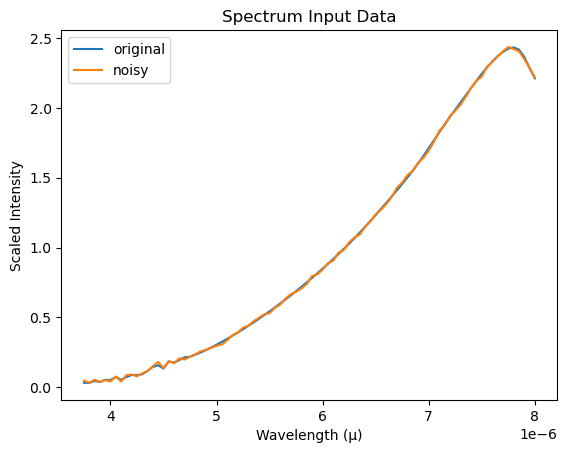

In [1356]:
plt.title('Spectrum Input Data')
plt.plot(spec.iloc[0], label='original')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [1357]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)
spec_unscaled = scaler.inverse_transform(spec_scaled)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [1358]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [1359]:
spec_unscaled

array([[0.03105584, 0.02999482, 0.04442183, ..., 2.36597201, 2.28558255,
        2.21152006],
       [0.02303472, 0.02137935, 0.03026088, ..., 1.71166774, 1.65682389,
        1.60630741],
       [0.03321009, 0.02824623, 0.03587004, ..., 4.49959521, 4.32960797,
        4.17304151],
       ...,
       [0.02847468, 0.02408754, 0.03030068, ..., 2.56521541, 2.47682096,
        2.39538243],
       [0.01648649, 0.01406005, 0.01783686, ..., 1.20163893, 1.16569548,
        1.13260748],
       [0.02009135, 0.01711356, 0.02174333, ..., 4.45698039, 4.28885161,
        4.13399539]])

In [1360]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,1.494065,0.656879,1.298247,0.826965,0.847702,0.359199,0.980361,-0.115378,0.958146,0.341181,...,-0.309340,-0.311486,-0.306351,-0.300584,-0.293805,-0.309761,-0.308301,-0.310515,-0.295965,-0.290126
1,0.116899,0.006460,0.042082,-0.803986,0.024469,-0.010392,-0.261590,-0.186548,0.803875,-0.244935,...,-0.787293,-0.791715,-0.785322,-0.776538,-0.785290,-0.778501,-0.805670,-0.809072,-0.780596,-0.790357
2,-0.037343,1.215705,-0.394521,0.311323,-0.037890,-0.018865,-0.334538,-0.069192,1.135329,0.336838,...,1.302744,1.317643,1.297508,1.304139,1.310118,1.307495,1.303355,1.308906,1.303079,1.315567
3,-1.099076,-1.917818,-1.177003,-1.328374,-1.035975,-1.207453,-0.478553,-0.558644,-0.648823,-0.741192,...,0.039482,0.030424,0.043418,0.050054,0.046899,0.051399,0.048878,0.048723,0.046039,0.052330
4,0.713801,0.186795,-0.105222,0.387861,-0.334526,-0.450377,-0.239418,0.673440,0.366146,0.415772,...,0.301591,0.300873,0.305298,0.305022,0.308429,0.311295,0.333900,0.316159,0.324881,0.318193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.735660,0.099442,-0.142663,0.544815,0.450951,1.589150,0.963165,0.238716,1.087100,0.639995,...,0.578975,0.567116,0.583741,0.566056,0.571007,0.583040,0.576835,0.568016,0.565757,0.583565
2196,-1.283490,-0.433721,0.224342,-0.426995,-0.730906,-1.295285,-0.659630,-0.559762,-0.462552,-0.363486,...,1.612797,1.600799,1.608914,1.593495,1.606566,1.598596,1.595521,1.601681,1.598766,1.604246
2197,1.155160,0.380589,-0.082138,0.424227,-0.727963,-0.895150,-0.035928,0.797729,-0.061653,-0.072103,...,-0.146454,-0.164778,-0.161873,-0.151496,-0.153702,-0.144310,-0.148293,-0.146233,-0.156069,-0.150451
2198,-1.019159,-1.312473,-0.869977,-1.156617,-1.254299,-0.979963,-1.468084,-1.377644,-1.352008,-1.649262,...,-1.167006,-1.164365,-1.163779,-1.174013,-1.177663,-1.179738,-1.181063,-1.178156,-1.176171,-1.165752


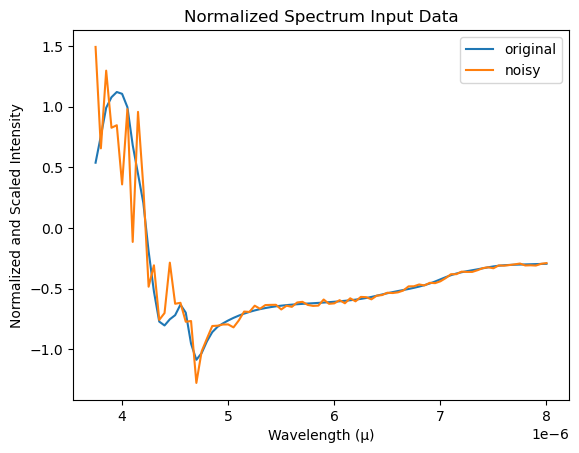

In [1361]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [1362]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [1363]:
# Feature Selection

In [1364]:
spec_train

tensor([[ 0.5789,  1.5945,  2.2913,  ...,  0.7132,  0.7132,  0.7031],
        [ 0.4318,  0.6662,  0.1797,  ..., -0.2738, -0.2867, -0.2861],
        [ 0.3314, -0.2887,  0.1063,  ..., -0.6664, -0.6770, -0.6885],
        ...,
        [ 1.2789,  1.7151,  1.1191,  ...,  1.9408,  1.9121,  1.9105],
        [-0.0686, -0.9716,  0.1457,  ..., -0.0940, -0.0917, -0.0803],
        [ 0.0578, -0.3838,  0.1024,  ...,  0.5110,  0.5071,  0.5240]])

In [1365]:
temp_train

tensor([[370.3413, 328.5613, 326.2462,  ..., 334.0032, 331.4733, 344.6604],
        [358.7178, 321.1420, 335.1217,  ..., 336.1974, 344.1709, 318.3873],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [370.2241, 340.5473, 330.7923,  ..., 343.7119, 361.5406, 369.9658],
        [308.7229, 320.0291, 305.8729,  ..., 333.4956, 311.0175, 324.1667],
        [338.4227, 306.0559, 297.0075,  ..., 323.1169, 302.0772, 340.2445]])

# Model Design

In [1366]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin4 = nn.Linear(30, 30)
        self.lin5 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, temp):
        x = F.leaky_relu(self.lin1(temp))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_spec = self.lin_fin(x)
        return pred_spec

In [1367]:
class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(io_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, middle_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [1368]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, spec_train):
        pred_temp = self.inverse_model(spec_train)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [1369]:
_, middle_size = temp.shape
_, io_size = spec_noisy_scaled_df.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(io_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)


x = torch.rand(1540, io_size)
print(forward_model(inverse_model(x)).shape)
pred_temp_x, pred_spec_x = tandem_net(x)
print(pred_spec_x.shape)

torch.Size([1540, 86])
torch.Size([1540, 86])


# Training Loop

In [1370]:
def train_forward_model(forward_model, temp_train):
    print('FORWARD MODEL TRAINING')

    forward_loss_list = []
    forward_loss_sum = 0

    num_forward_epochs = args['forward training epochs']
    criterion = args['forward training criterion']
    optimizer = args['optimizer'](forward_model.parameters(), lr=args['forward learning rate'])

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        pred_spec = forward_model(temp_train)
        loss = criterion(spec_train, pred_spec)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            forward_loss_sum += loss.item()

        forward_loss_list.append(loss.item())

        if (epoch + 1) % (num_forward_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, forward loss = {loss}')

    avg_forward_loss = forward_loss_sum / (num_forward_epochs - 100)
    print(f'\nAVERAGE FORWARD LOSS: {avg_forward_loss}')

    return forward_loss_list
        

In [1371]:
def train_inverse_model(tandem_net, spec_train):
    print('\nINVERSE MODEL TRAINING')

    # Fix the parameters of the forward model
    for param in forward_model.parameters():
        param.requires_grad = False

    tandem_loss_list = []
    inverse_loss_list = []
    
    inverse_loss_sum = 0

    num_inverse_epochs = args['inverse training epochs']
    criterion = args['inverse training criterion']
    optimizer = args['optimizer'](tandem_net.parameters(), lr=args['inverse learning rate'])

    for epoch in range(num_inverse_epochs):
        # pass through tandem model and calculate loss
        pred_temp, pred_spec = tandem_net(spec_train)
        loss = criterion(spec_train, pred_spec)

        pred_temp = inverse_model(spec_train)

        # calculate inverse loss (too see spec to temp accuracy)
        inverse_loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        inverse_loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            inverse_loss_sum += inverse_loss.item()

        # tandem_loss_list.append(loss.item())
        inverse_loss_list.append(inverse_loss.item())

        if (epoch + 1) % (num_inverse_epochs / 10) == 0:
            print(f'forward epoch: {epoch + 1}, tandem loss = {loss}, inverse loss = {inverse_loss}')
            # print(f'forward epoch: {epoch + 1}, inverse loss = {inverse_loss}')

    avg_inverse_loss = inverse_loss_sum / (num_inverse_epochs - 100)
    print(f'\naverage inverse training loss (across all layers): {avg_inverse_loss}')
    
    return tandem_loss_list, inverse_loss_list

In [1372]:
forward_loss_list = train_forward_model(forward_model, temp_train)
tandem_loss_list, inverse_loss_list = train_inverse_model(tandem_net, spec_train)

FORWARD MODEL TRAINING


forward epoch: 100, forward loss = 0.4001503884792328
forward epoch: 200, forward loss = 0.3436748683452606
forward epoch: 300, forward loss = 0.1973923295736313
forward epoch: 400, forward loss = 0.15596523880958557
forward epoch: 500, forward loss = 0.15019938349723816
forward epoch: 600, forward loss = 0.1484077125787735
forward epoch: 700, forward loss = 0.1478571891784668
forward epoch: 800, forward loss = 0.14751416444778442
forward epoch: 900, forward loss = 0.14722678065299988
forward epoch: 1000, forward loss = 0.14705757796764374

AVERAGE FORWARD LOSS: 0.188490681797266

INVERSE MODEL TRAINING
forward epoch: 100, tandem loss = 0.31995394825935364, inverse loss = 10.127099990844727
forward epoch: 200, tandem loss = 0.20909613370895386, inverse loss = 7.393355369567871
forward epoch: 300, tandem loss = 0.18529878556728363, inverse loss = 6.970397472381592
forward epoch: 400, tandem loss = 0.17753241956233978, inverse loss = 6.751396179199219
forward epoch: 500, tandem loss = 0.

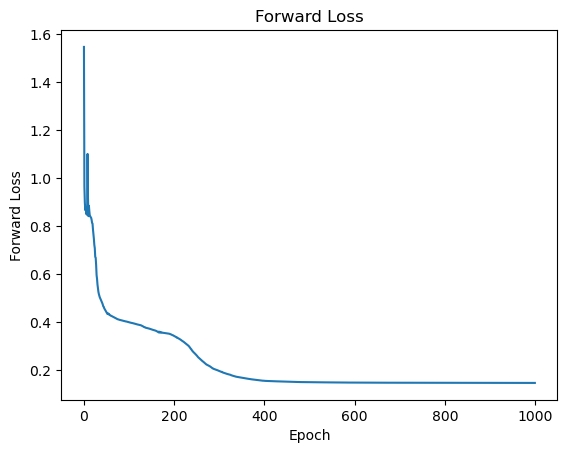

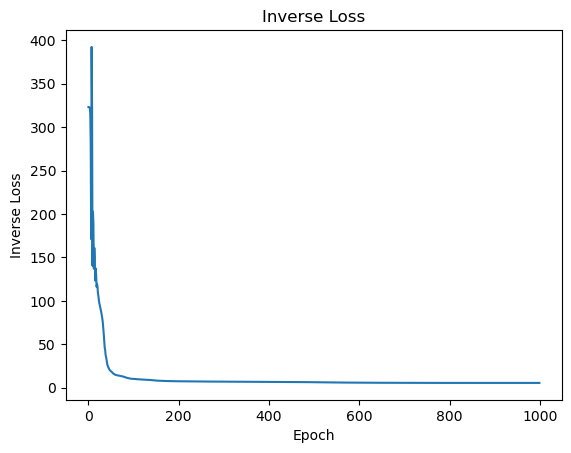

In [1373]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()


# # plot tandem loss
# plt.plot(tandem_loss_list)

# plt.title("Tandem Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Tandem Loss")
# plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()

# Testing

In [1374]:
# test data through tandem net
pred_temp, pred_spec = tandem_net(spec_test)

In [1375]:
# unscale spectrum data
pred_spec = scaler.inverse_transform(pred_spec.detach().numpy())
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [1376]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [8.56320019346295, 9.247595076127485, 5.9908235492128314, 5.986219926313921, 5.845527140299479, 6.659904942368016, 6.1014476429332385, 4.50562129165187, 4.602777330803149, 6.198890454841383, 1.8906449751420455]


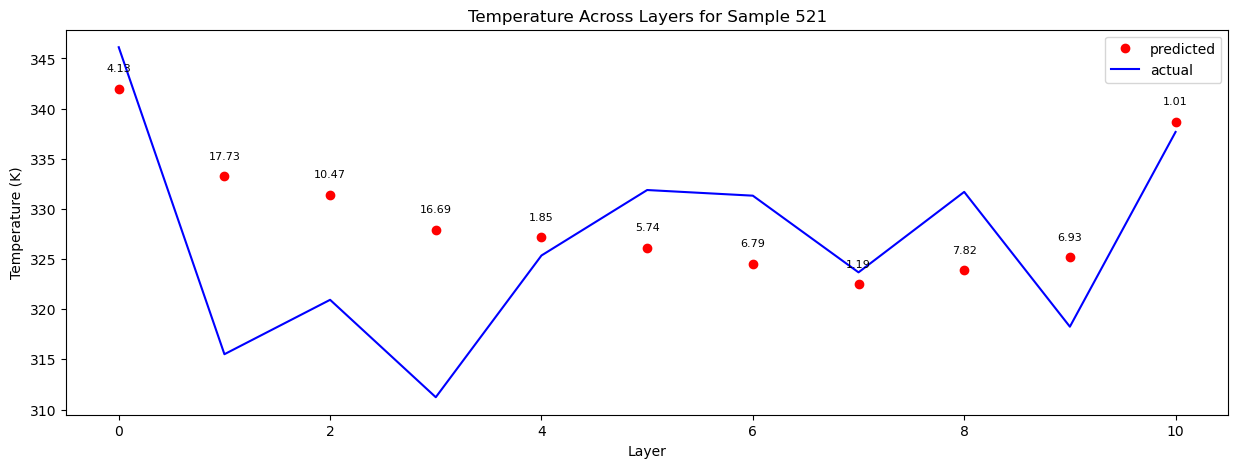

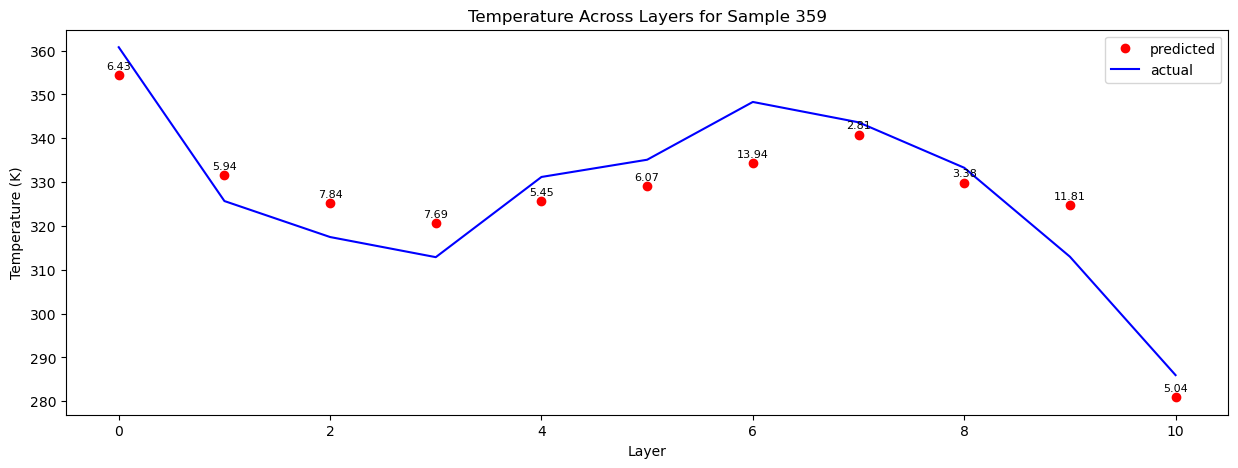

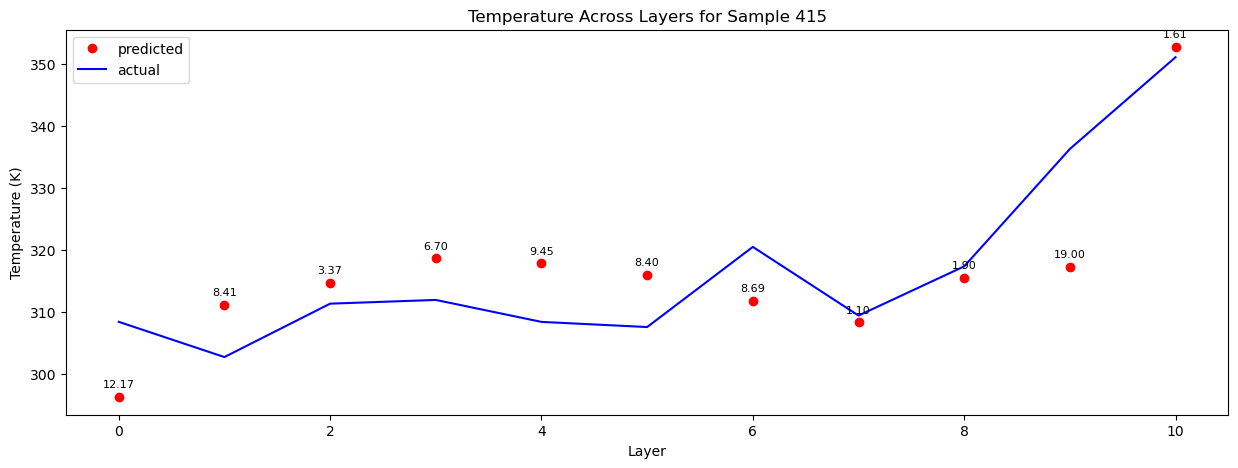

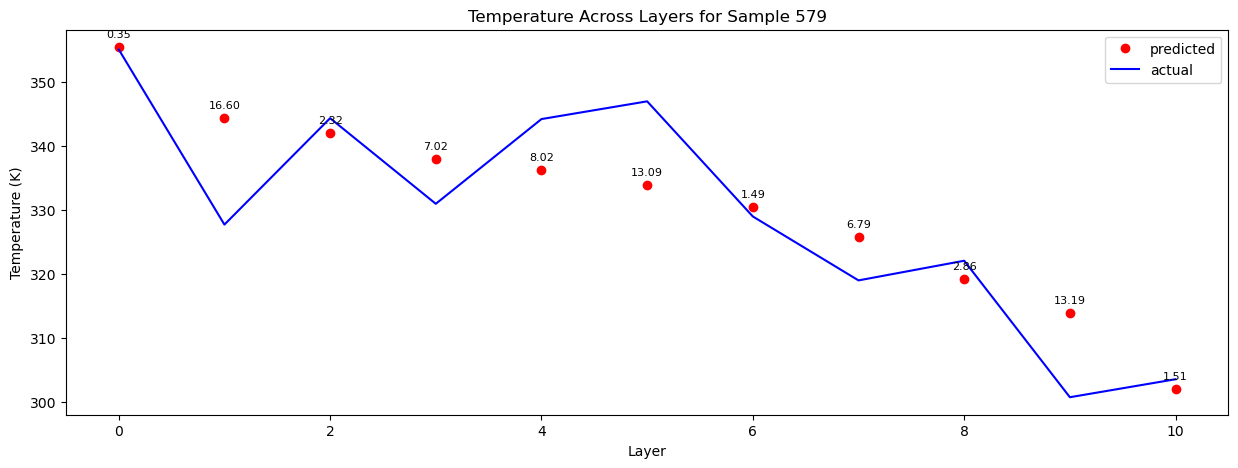

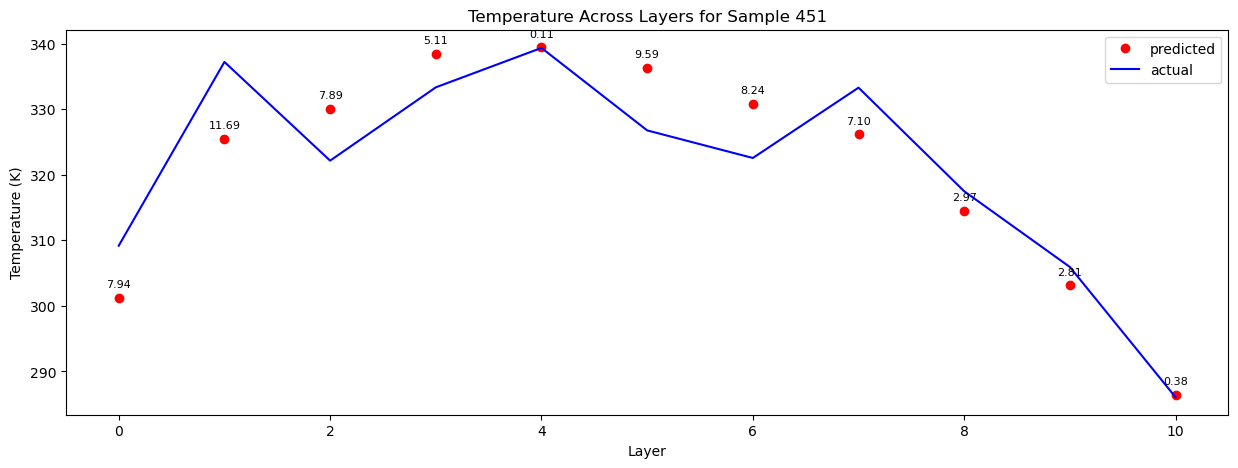

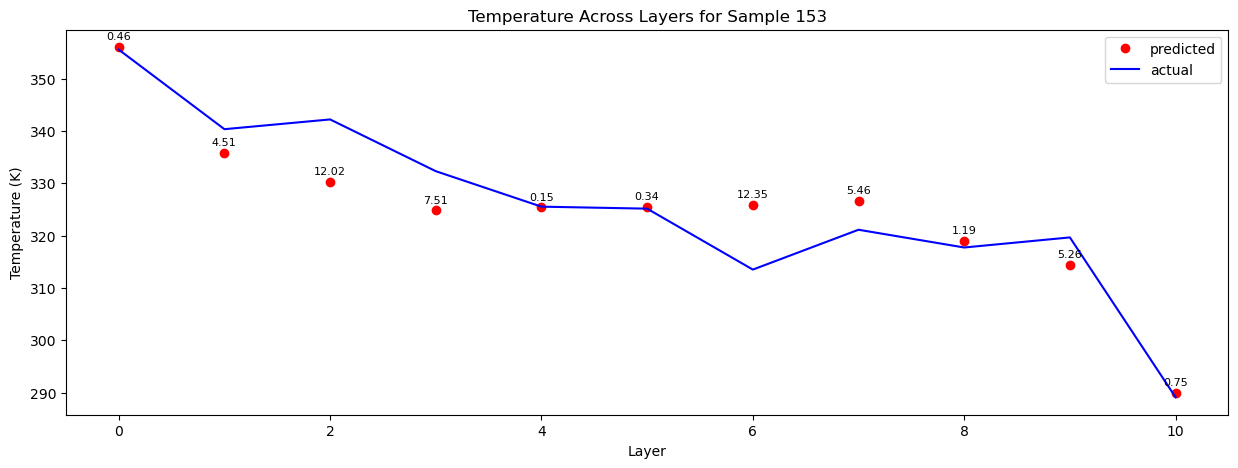

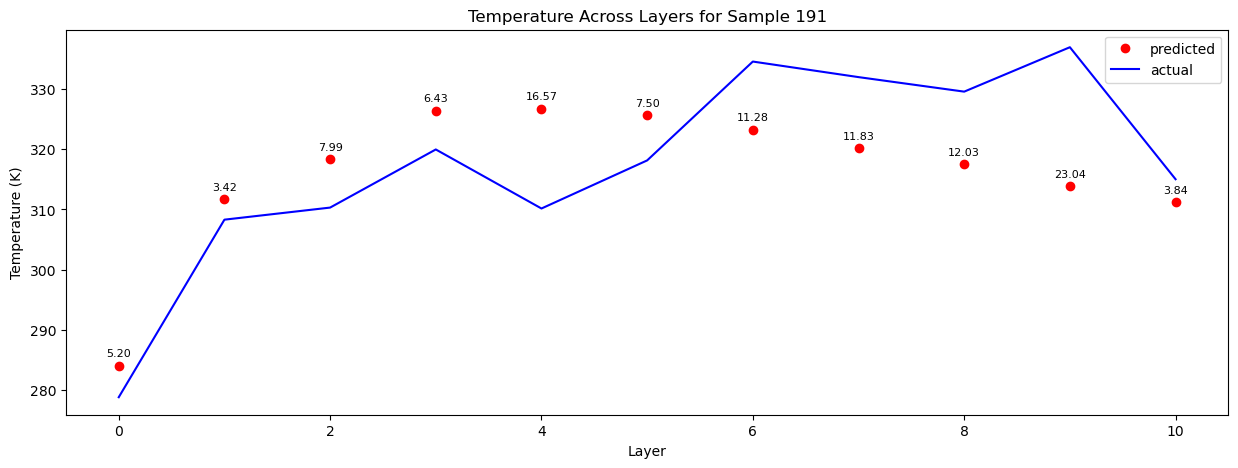

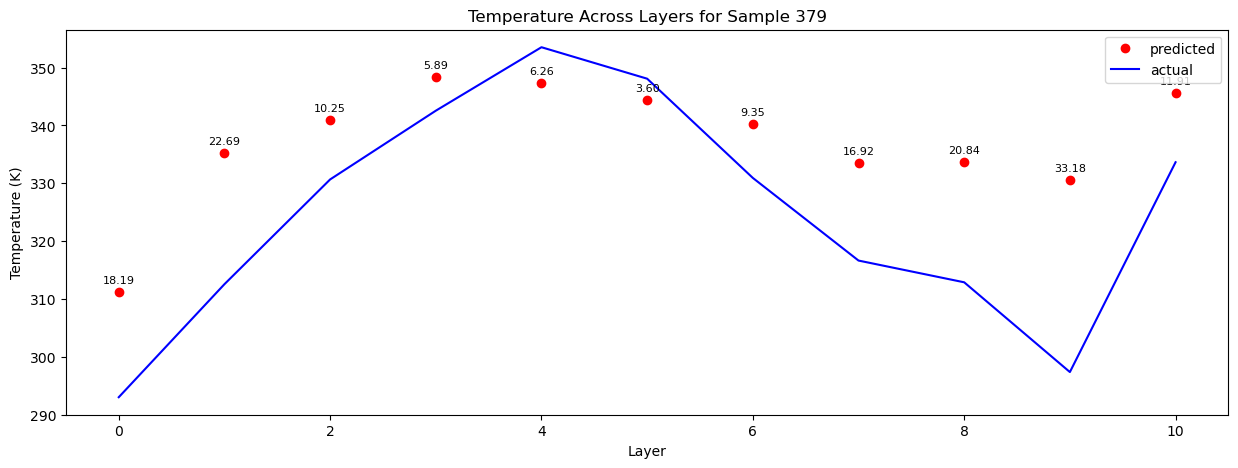

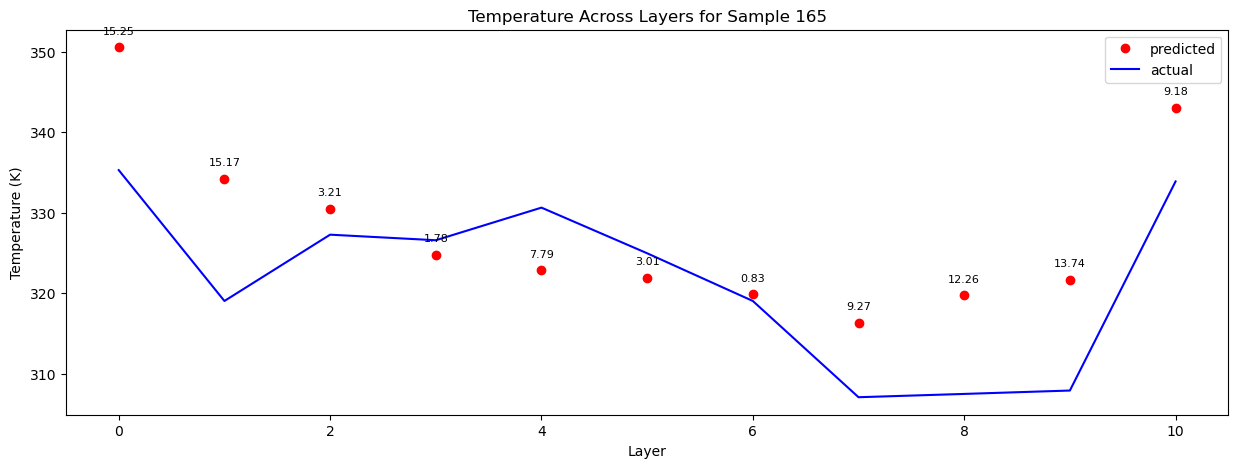

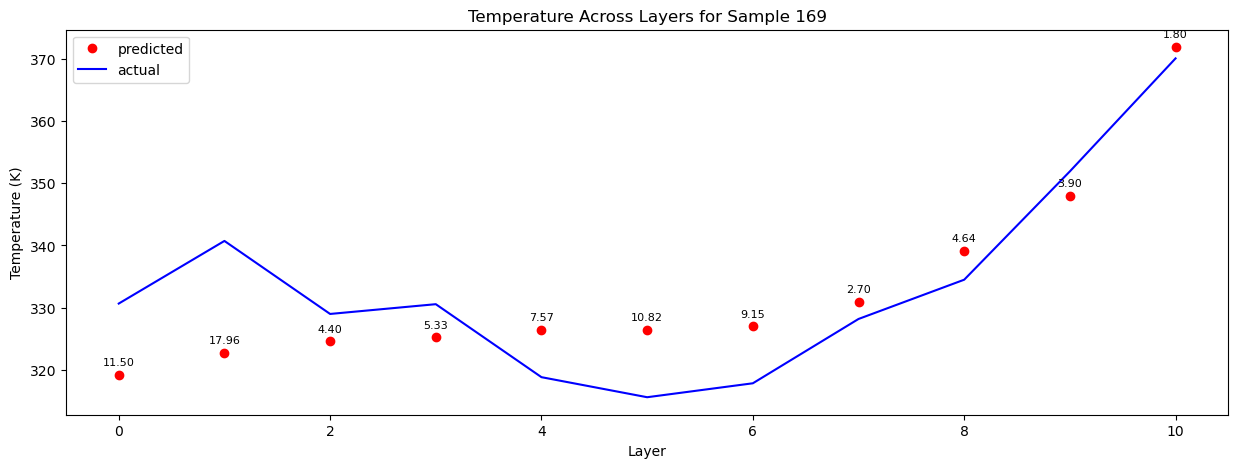

In [1381]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


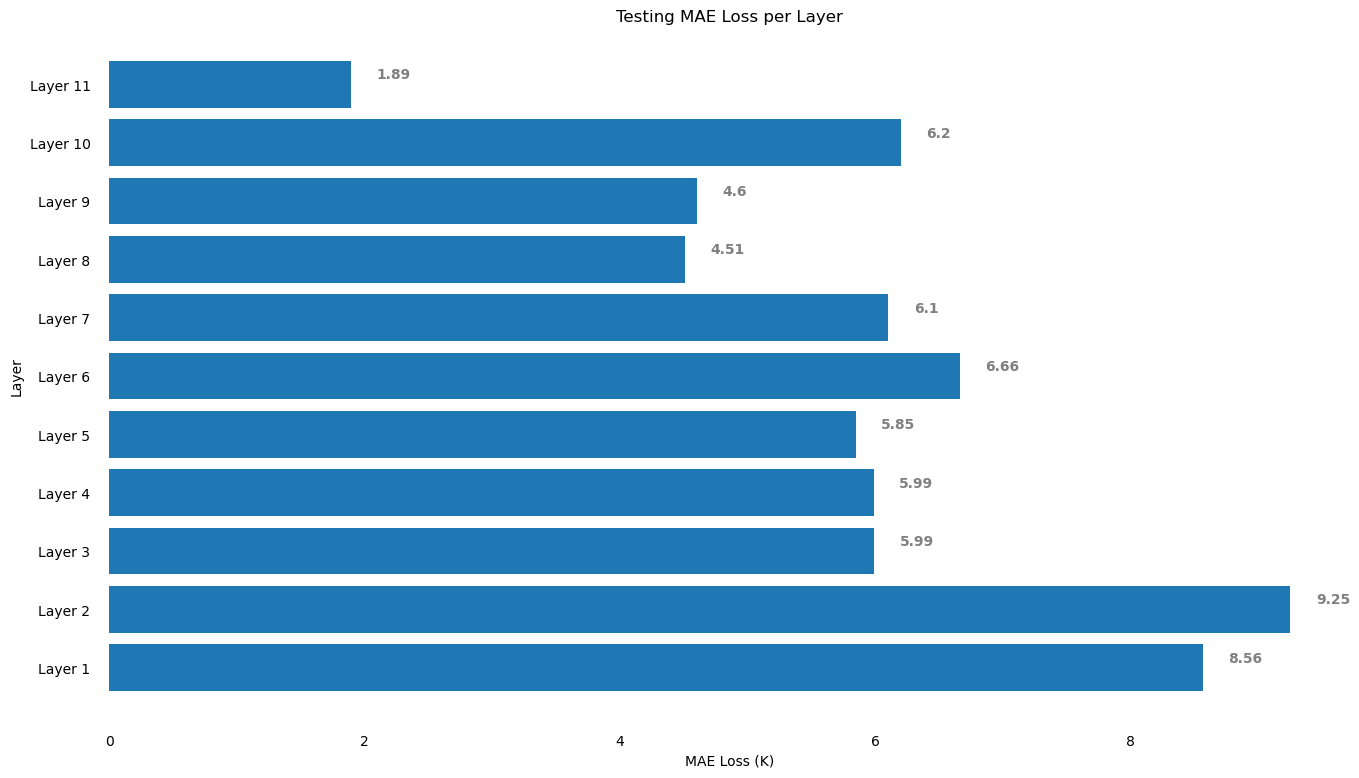

In [1378]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()